In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import deepdish as dd
from scipy.stats import bootstrap

import plot_utils as pu
from digest import conds, voltage_measures

import conf.isi3_mouse as cfg

In [2]:
# hists = dd.io.load(cfg.digestfile.format(kind='histograms'))
# masked_hists = dd.io.load(cfg.digestfile.format(kind='masked_histograms'))
nspikes = dd.io.load(cfg.digestfile.format(kind='nspikes-neuronmean') + '.h5')

In [3]:
width, height = 5, 10

In [4]:
def pairlabel(ipair):
    return f'{cfg.pairings[ipair][0]}/{cfg.pairings[ipair][1]}'

In [5]:
def isiterable(obj):
    try:
        iter(obj)
    except TypeError:
        return False
    else:
        return True

In [6]:
def getindex(**kwargs):
    if 'isi' in kwargs:
        if isiterable(kwargs['isi']):
            iISI = [cfg.ISIs.index(isi) for isi in kwargs['isi']]
        else:
            iISI = cfg.ISIs.index(kwargs['isi'])
    else:
        iISI = kwargs.get('iISI', slice(None))
    if 'cond' in kwargs:
        if isiterable(kwargs['cond']) and not isinstance(kwargs['cond'], str):
            icond = [conds.index(cond) for cond in kwargs['cond']]
        else:
            icond = conds.index(kwargs['cond'])
    else:
        icond = kwargs.get('icond', slice(None))
    return (
        kwargs.get('templ', slice(None)),
        kwargs.get('net', slice(None)),
        kwargs.get('STD', slice(None)),
        kwargs.get('TA', slice(None)),
        iISI,
        kwargs.get('ipair', slice(None)),
        kwargs.get('istim', slice(None)),
        icond)

In [7]:
def getlabels(ntempl, with_cond, **kwargs):
    title_chunks = []
    descriptor_chunks = []

    templ_ = kwargs.get('templ', range(ntempl))
    if isiterable(templ_):
        title_chunks.append([f'template {templ}' for templ in templ_])
    else:
        descriptor_chunks.append(f'template {templ_}')

    net_ = kwargs.get('net', range(cfg.N_networks))
    if isiterable(net_):
        title_chunks.append([f'net {net}' for net in net_])
    else:
        descriptor_chunks.append(f'net {net_}')

    STD_ = kwargs.get('STD', cfg.STDs)
    if isiterable(STD_):
        title_chunks.append([f'STD {STD}' for STD in STD_])
    else:
        descriptor_chunks.append(f'STD {STD_}')

    TA_ = kwargs.get('TA', cfg.TAs)
    if isiterable(TA_):
        title_chunks.append([f'TA {TA}' for TA in TA_])
    else:
        descriptor_chunks.append(f'TA {TA_}')

    isi_ = kwargs.get('isi', cfg.ISIs[kwargs.get('iISI', slice(None))])
    if isiterable(isi_):
        title_chunks.append([f'ISI {isi} ms' for isi in isi_])
    else:
        descriptor_chunks.append(f'ISI {isi_} ms')

    if 'ipair' not in kwargs or 'istim' not in kwargs:
        raise NotImplemented
    else:
        descriptor_chunks.append(f'pair {pairlabel(kwargs["ipair"])}')
        descriptor_chunks.append(f'stim {cfg.pairings[kwargs["ipair"]][kwargs["istim"]]}')

    if with_cond:
        cond_ = kwargs.get('cond', conds[kwargs.get('icond', slice(None))])
        if isiterable(cond_) and not isinstance(cond_, str):
            title_chunks.append(cond_)
        else:
            descriptor_chunks.append(cond_)

    return [', '.join(chunk) for chunk in itertools.product(*title_chunks)], ', '.join(descriptor_chunks)

In [8]:
def hist_view(hists, **kwargs):
    return hists[getindex(**kwargs)].reshape(-1, *hists.shape[-2:])

def hist_labels(hists, **kwargs):
    return getlabels(hists.shape[0], True, **kwargs)

def nspikes_labels(**kwargs):
    return getlabels(cfg.N_templates, False, **kwargs)

In [9]:
def get_onset_ordering(pspike, limit=None, filter=None, **kwargs):
    if len(pspike.shape) > 3:
        pspike = hist_view(pspike, **kwargs)
    elif len(pspike.shape) == 2:
        pspike = pspike[None, :, :]
    hist_sum = pspike.sum(0)
    first_index = np.sum(np.cumsum(hist_sum, axis=1) == 0, axis=1)
    safe_first_index = first_index.copy()
    safe_first_index[first_index >= hist_sum.shape[1]] = 0
    first_intensity = hist_sum[np.arange(hist_sum.shape[0]), safe_first_index]
    onset_sort = np.lexsort((-first_intensity, first_index))
    order = onset_sort[:limit]
    if filter is not None:
        order = order[np.isin(order, filter)]
    tmax = np.flatnonzero(hist_sum[order].sum(axis=0))[-1] + 1
    return order, tmax

In [10]:
def plot_hists(hists, selection, tmax, title='', width=width, height=height, **kwargs):
    labels, descriptor = hist_labels(hists['p(spike)'], **kwargs)
    pspike = hist_view(hists['p(spike)'], **kwargs)
    voltages = [hist_view(hists[m], **kwargs) for m in voltage_measures]
    
    fig, axs, cb = pu.plot_pulse_hist(
        pspike, selection, tmax, cfg.params['dt'],
        figsize=(width*len(pspike), height), symmetric=False, cmap='turbo')
    for ax, label in zip(axs, labels):
        ax.set_title(label)
    fig.suptitle('\n'.join(filter(None, [title, 'p(spike)', descriptor])))
    cb.set_label('p(spike)')
    
    for measure, voltage in zip(voltage_measures, voltages):
        fig, axs, cb = pu.plot_pulse_hist(
            voltage*1000, selection, tmax, cfg.params['dt'],
            figsize=(width*len(voltage), height), symmetric=False, cmap='turbo')
        for ax, label in zip(axs, labels):
            ax.set_title(label)
        fig.suptitle('\n'.join(filter(None, [title, measure, descriptor])))
        cb.set_label(f'{measure} (mV)')
    plt.show()
    plt.close('all')

In [11]:
def plot_contrasts(hists, selection, tmax, title='', width=width, height=height, **kwargs):
    pspike = hist_view(hists['p(spike)'], **kwargs)
    assert len(pspike) == 2
    voltages = [hist_view(hists[m], **kwargs) for m in voltage_measures]
    labels, descriptor = hist_labels(hists['p(spike)'], **kwargs)
    
    fig, axs, cb = pu.plot_pulse_hist(
        [pspike[0] - pspike[1]], selection, tmax, cfg.params['dt'],
        figsize=(width, height), symmetric=True, cmap=pu.ccc_divergent)
    fig.suptitle('\n'.join(filter(None, [title, 'p(spike)', descriptor, f'{labels[0]} - {labels[1]}'])))
    cb.set_label(f'p(spike)')

    fig, axs, cb, orders = pu.plot_pulse_hist(
        [(voltage[0] - voltage[1])*1000 for voltage in voltages], selection, tmax, cfg.params['dt'],
        figsize=(width*len(voltages), height), symmetric=True, cmap=pu.ccc_divergent, cscale=True)
    for ax, measure, order in zip(axs, voltage_measures, orders):
        ax.set_title(f'{measure} * 10^{order}' if order else measure)
    fig.suptitle('\n'.join(filter(None, [title, measure, descriptor, f'{labels[0]} - {labels[1]}'])))
    cb.set_label(f'$\\Delta$ contributions, {labels[0]} - {labels[1]} (mV)')

    plt.show()
    plt.close('all')

In [12]:
def plot_nspikes(nspikes, title='', figsize=(6,3), **kwargs):
    cond_ = kwargs.get('cond', conds[kwargs.get('icond', slice(None))])
    if isinstance(cond_, str):
        cond_ = [cond_]
    idx = getindex(**kwargs)[:-1]
    data = np.transpose([nspikes[cond][idx].mean(axis=-1).flatten() for cond in cond_])
    labels, descriptor = nspikes_labels(**kwargs)
    fig, ax = plt.subplots(figsize=figsize)
    pu.grouped_bars(data, cond_, labels, ax)
    ax.set_title('\n'.join(filter(None, [title, 'Spike count', descriptor])))
    ax.set_ylabel('# spikes per pulse & neuron')

In [13]:
def plot_ddi(nspikes, title='', figsize=(6,3), **kwargs):
    idx = getindex(**kwargs)[:-1]
    data = [nspikes[cond][idx].mean(axis=-1).flatten() for cond in ('dev', 'msc')]
    ddi = (data[0]-data[1]) / (data[0]+data[1])
    labels, descriptor = nspikes_labels(**kwargs)
    fig, ax = plt.subplots(figsize=figsize)
    for label, di in zip(labels, ddi):
        ax.bar(label, di)
    ax.set_title('\n'.join(filter(None, [title, 'Deviance detection index', descriptor])))
    ax.set_ylabel('DDI')

Included 36/120 stimuli


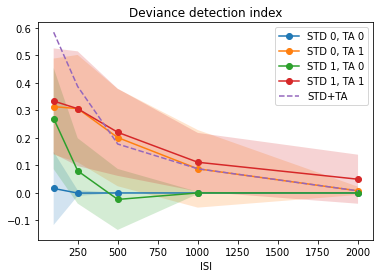

In [16]:
fig, ax = plt.subplots()
summed = 0
n0, n1 = [nspikes[cond][getindex(STD=1, TA=1)[:-1]].mean(-1)
          for cond in ('dev', 'msc')]  # templ, net, isi, pair, stim
ddi = np.moveaxis(((n0-n1)/(n0+n1)), 2, 0)  # isi, templ, net, pair, stim
ddi_perstim = ddi.mean(axis=1)
mask = (ddi_perstim <= 0).sum(axis=0) == 0  # net, pair, stim

for STD in cfg.STDs:
    for TA in cfg.TAs:
        n0, n1 = [nspikes[cond][getindex(STD=STD, TA=TA)[:-1]].mean(-1)
                  for cond in ('dev', 'msc')]
        ddi = np.moveaxis(((n0-n1)/(n0+n1)), 2, 0)[:, :, mask]
        ddi_mean = ddi.mean(axis=tuple(range(1, len(ddi.shape))))
        ddi_std = ddi.std(axis=tuple(range(1, len(ddi.shape))))
        ax.fill_between(cfg.ISIs, ddi_mean-ddi_std, ddi_mean+ddi_std, alpha=.2)
        ax.plot(cfg.ISIs, ddi_mean, '-o', label=f'STD {STD}, TA {TA}')
        if STD+TA == 1:
            summed = summed + ddi_mean
ax.plot(cfg.ISIs, summed, '--', label='STD+TA')
ax.set_title(f'Deviance detection index')
ax.set_xlabel('ISI')
plt.legend()
print(f'Included {mask.sum()}/{mask.size} stimuli')

WARNING    /tmp/ipykernel_303634/3229353932.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 5, figsize=(30,4))
 [py.warnings]


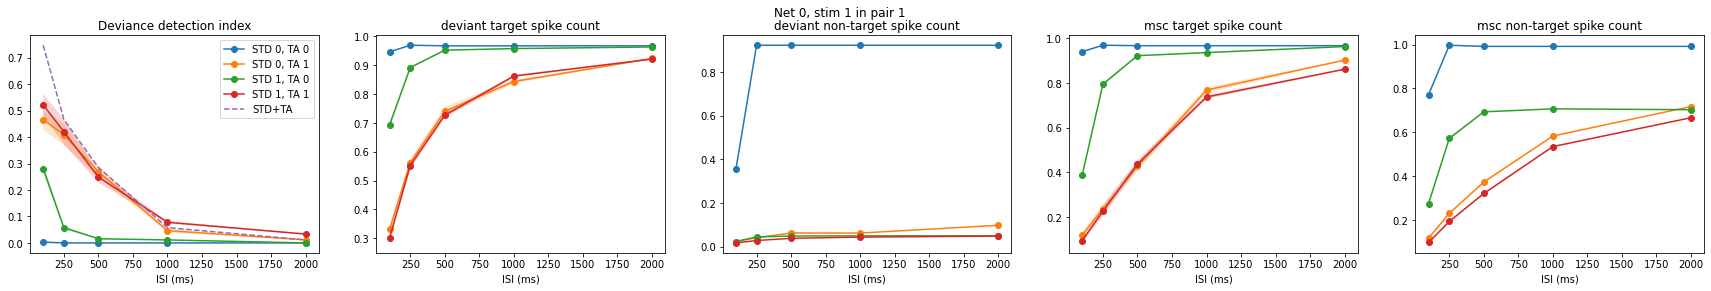

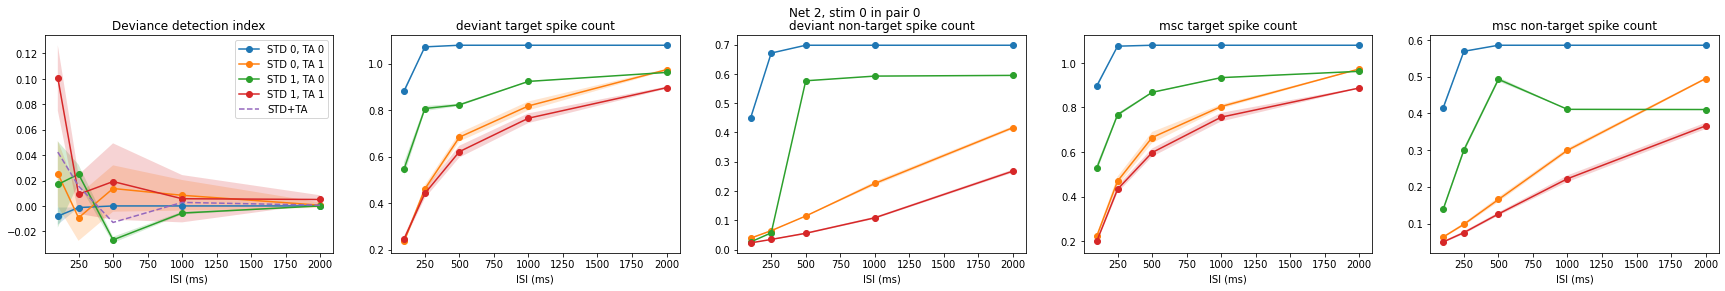

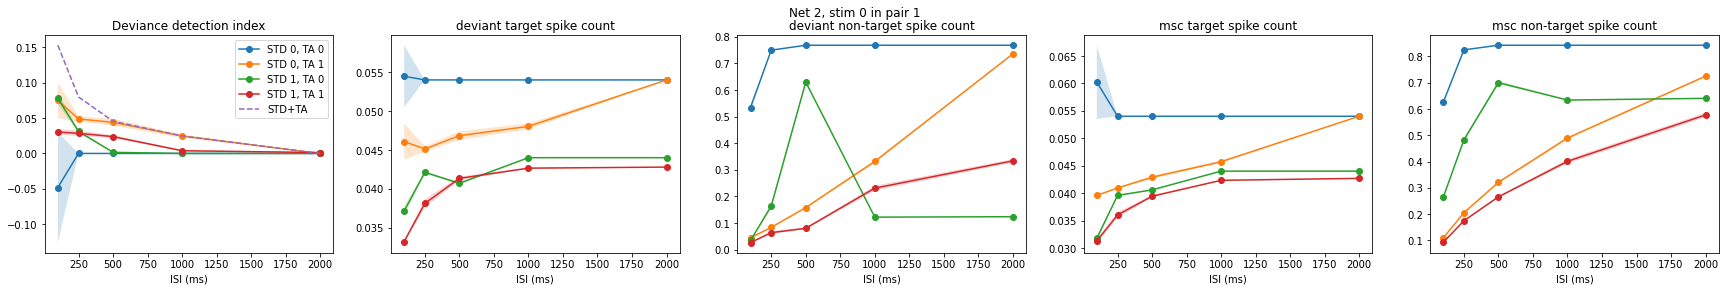

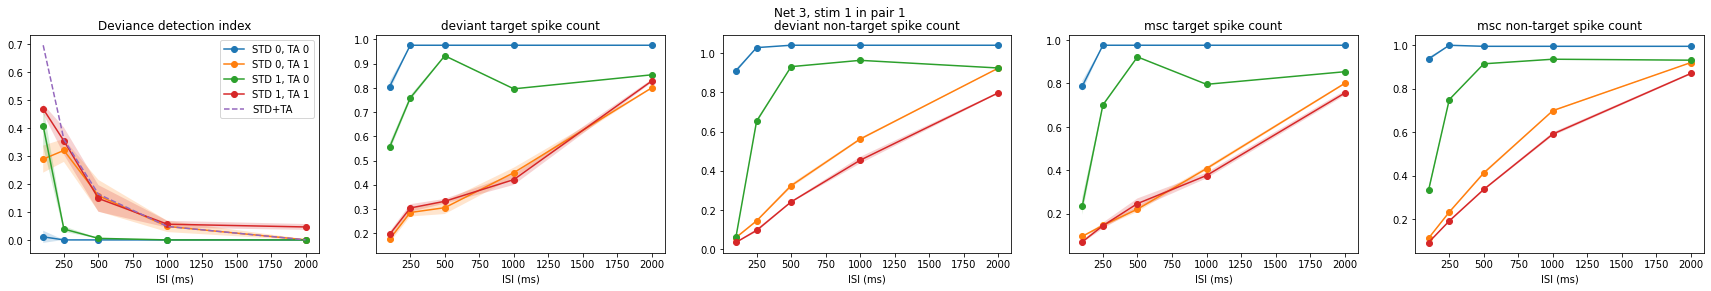

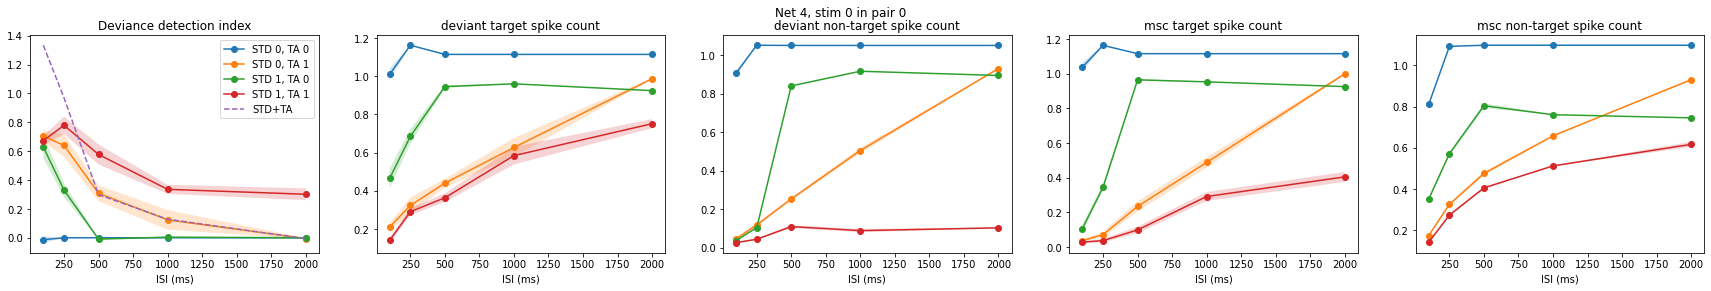

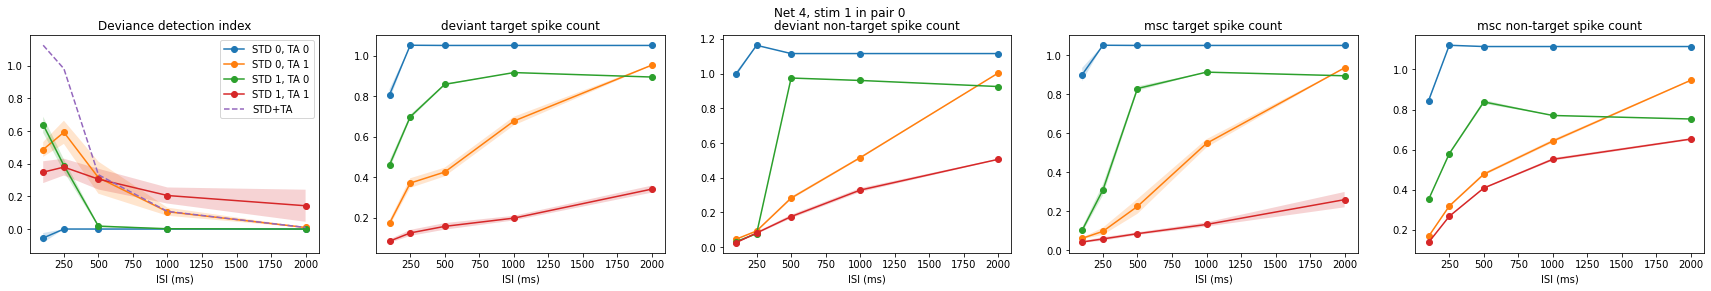

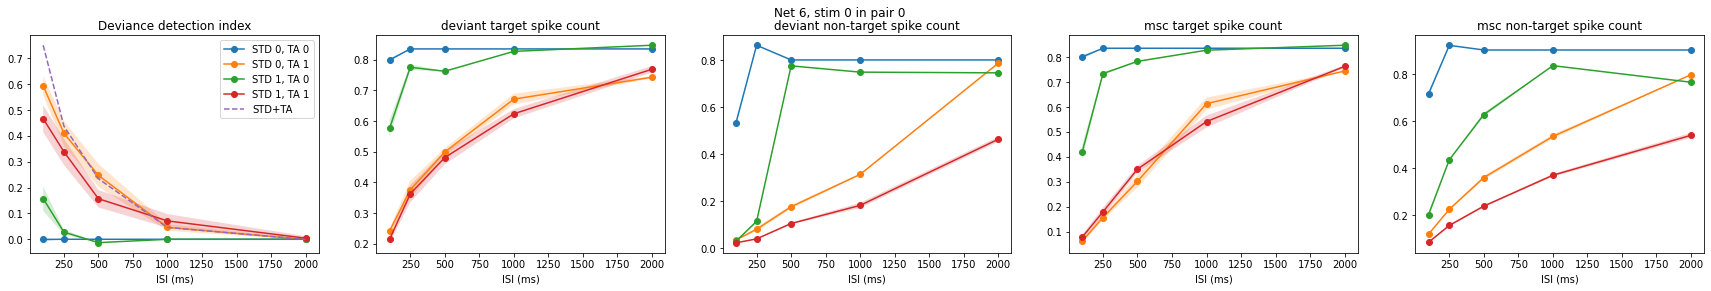

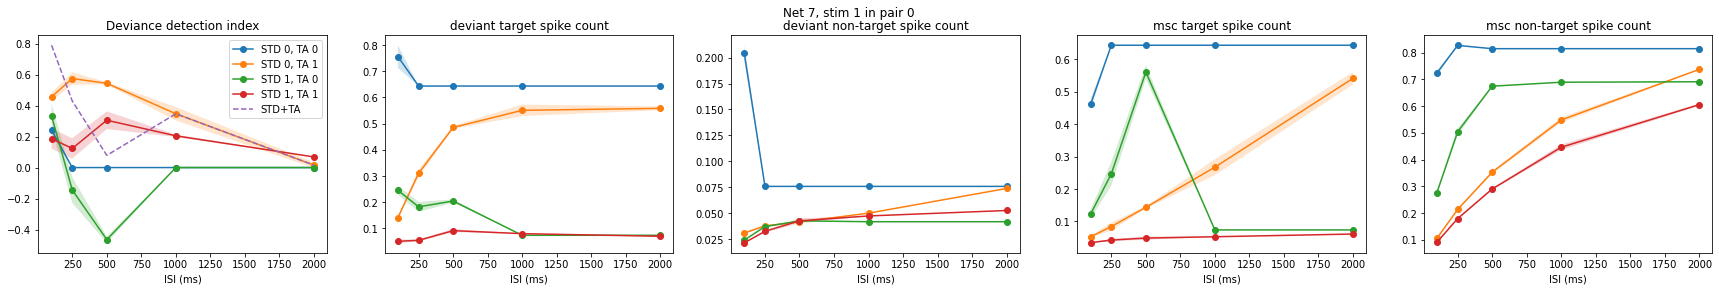

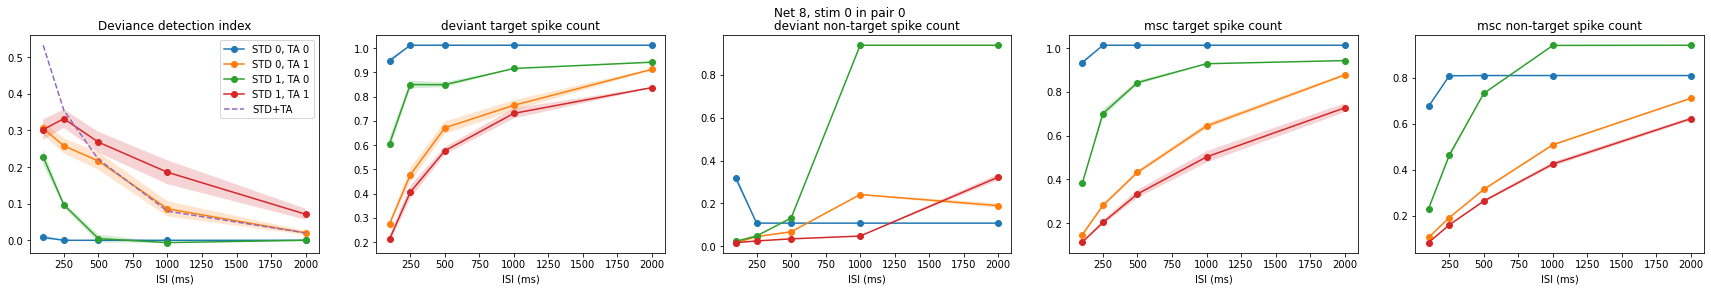

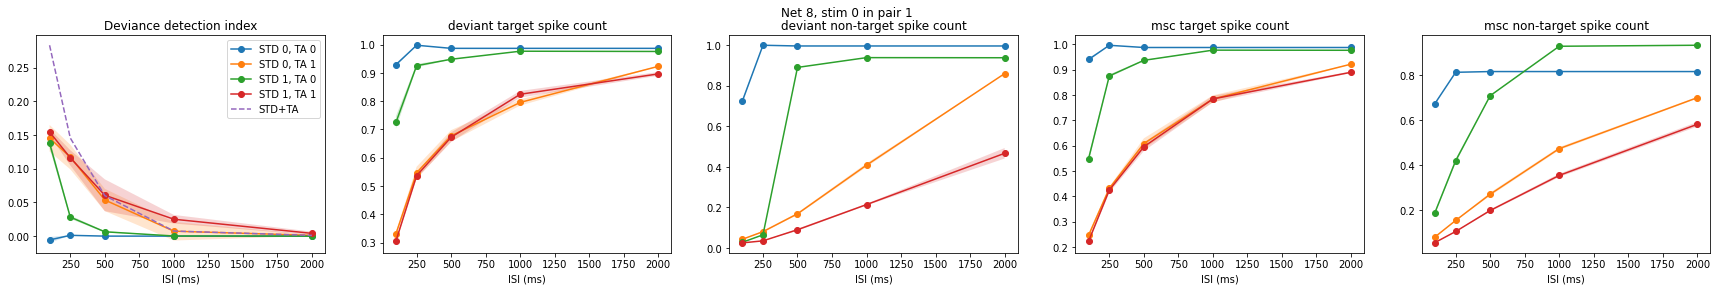

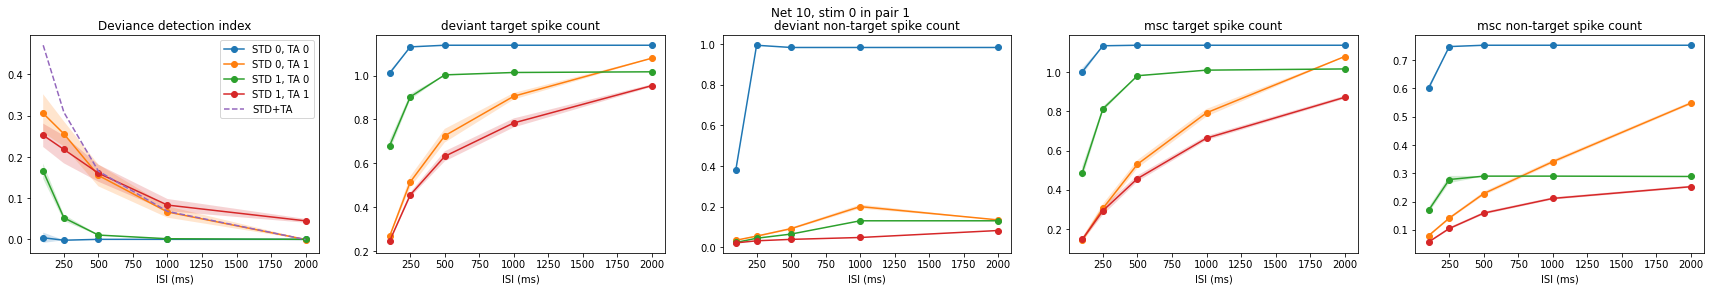

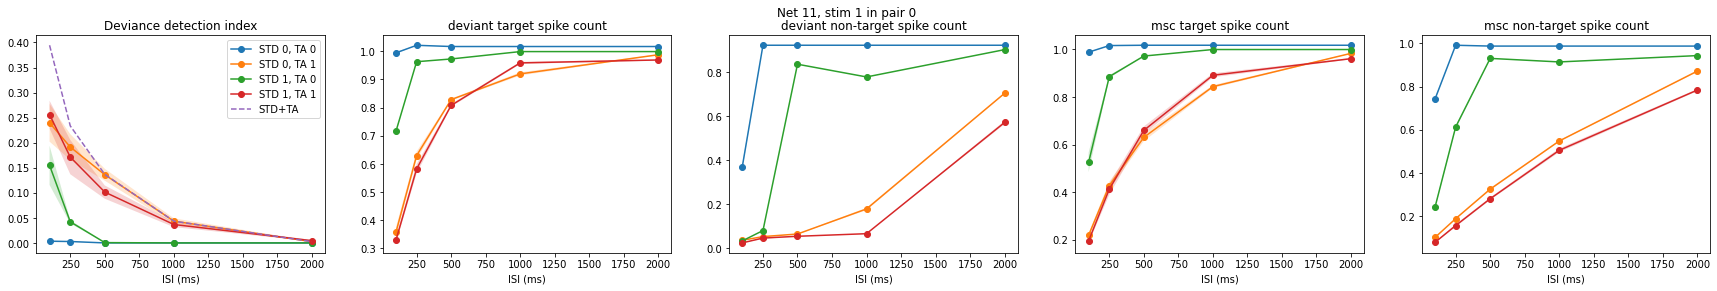

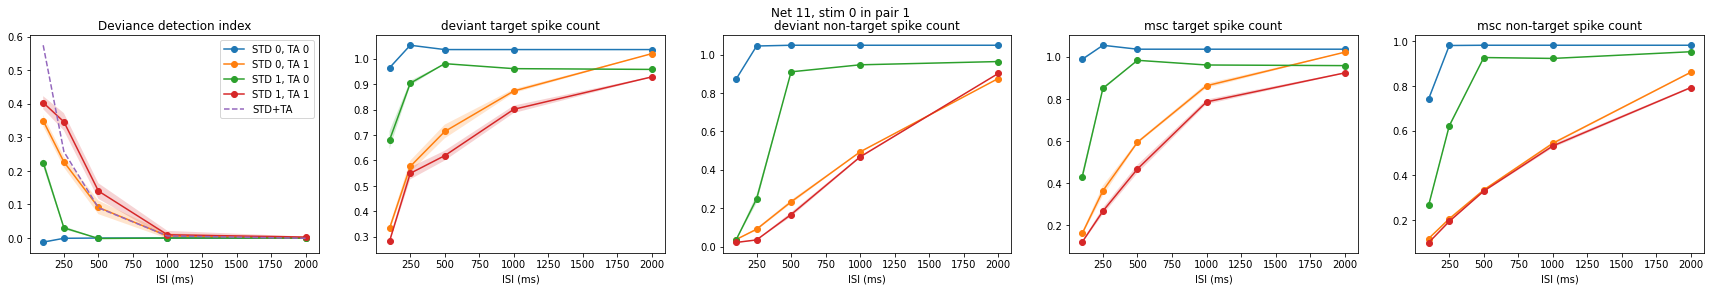

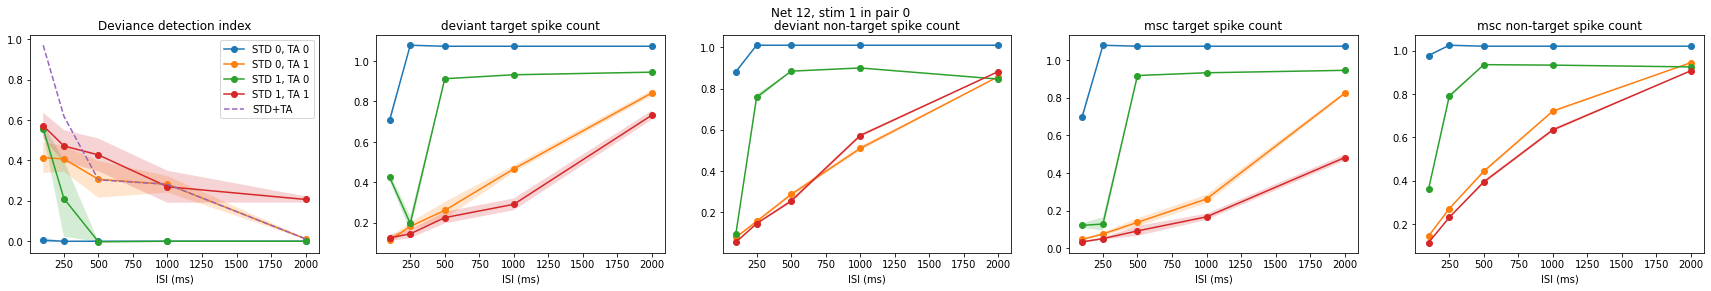

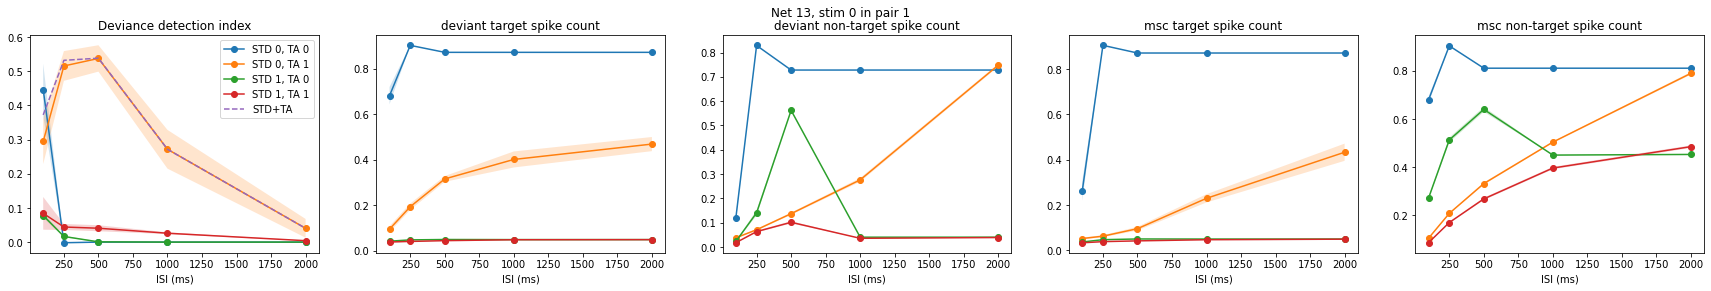

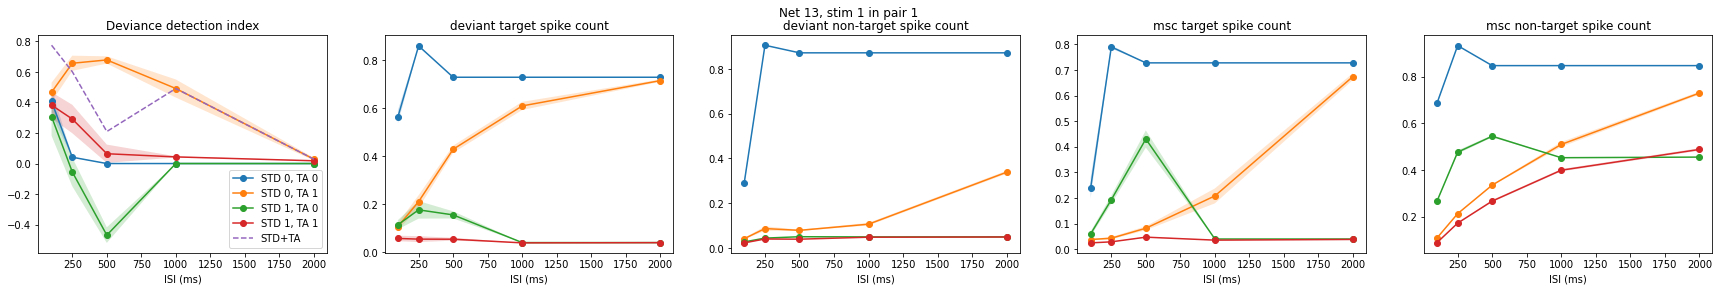

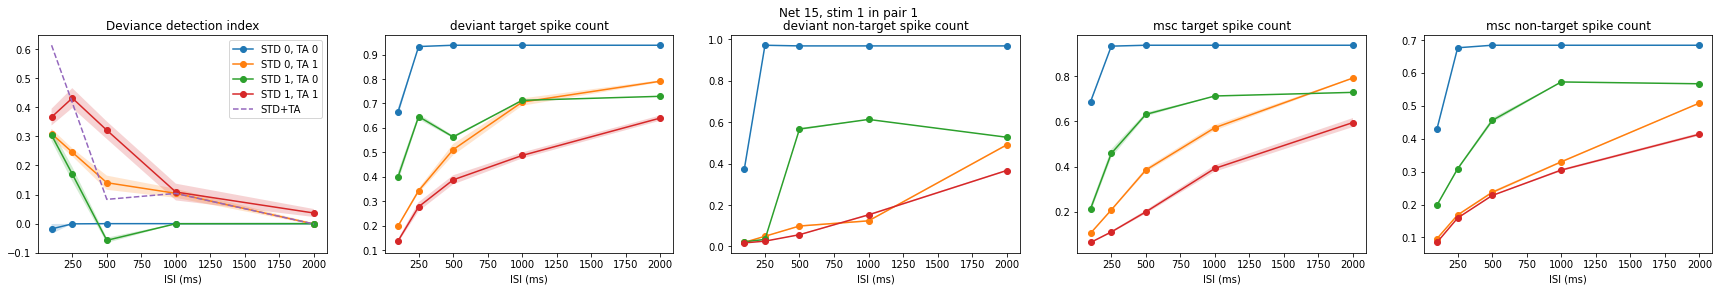

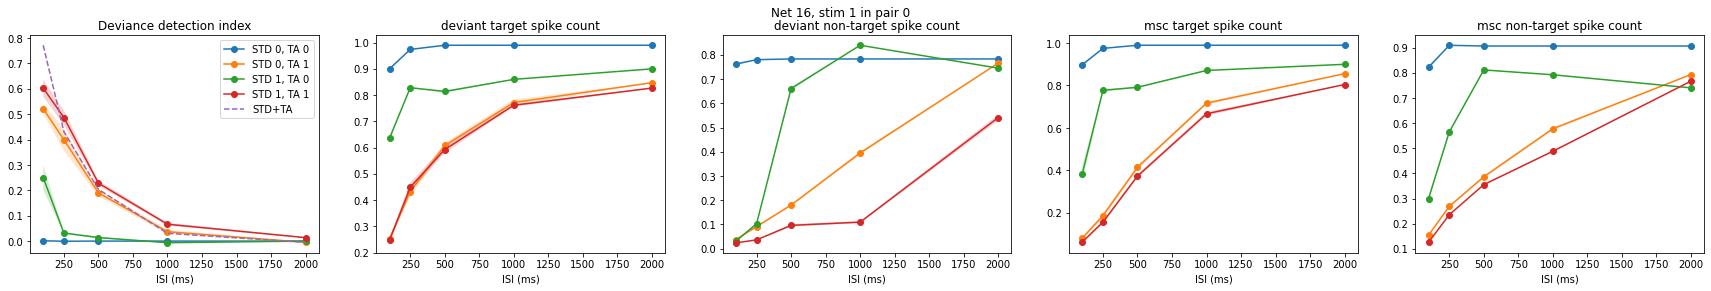

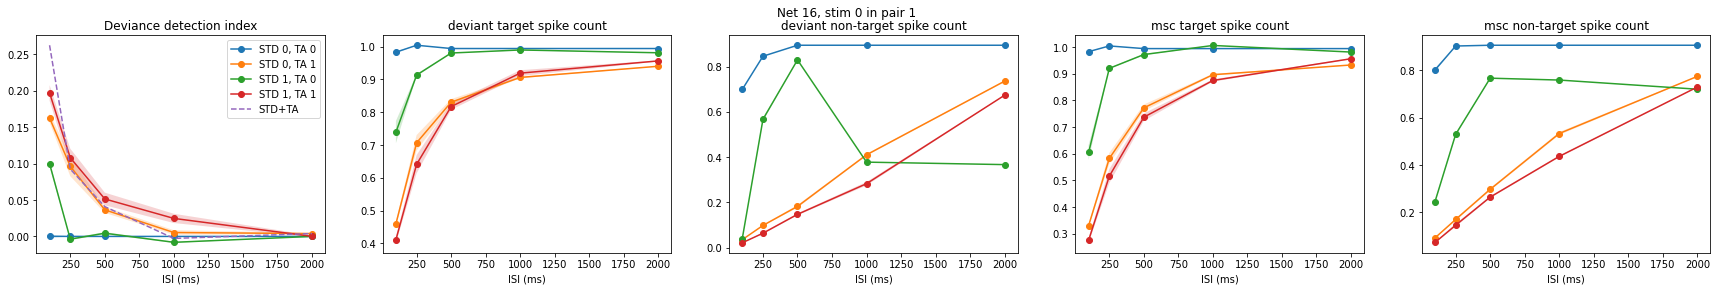

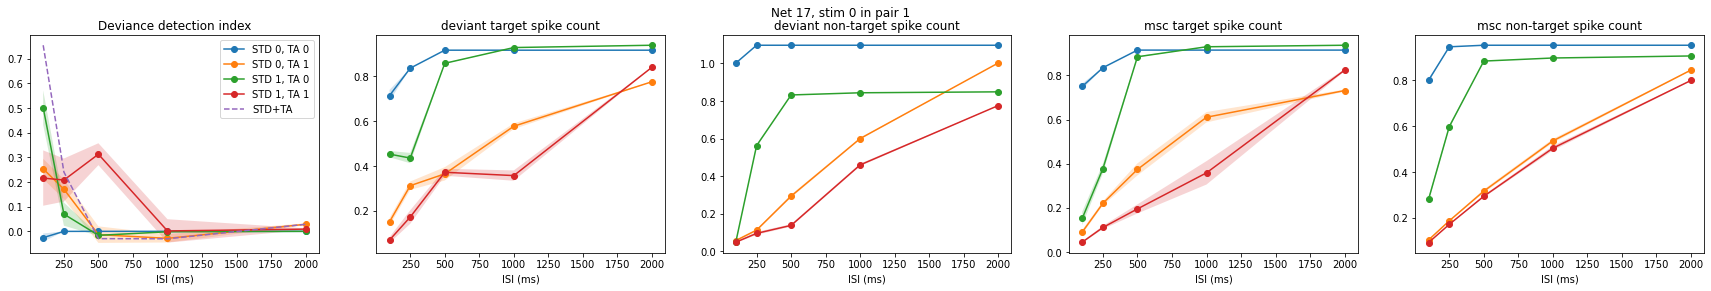

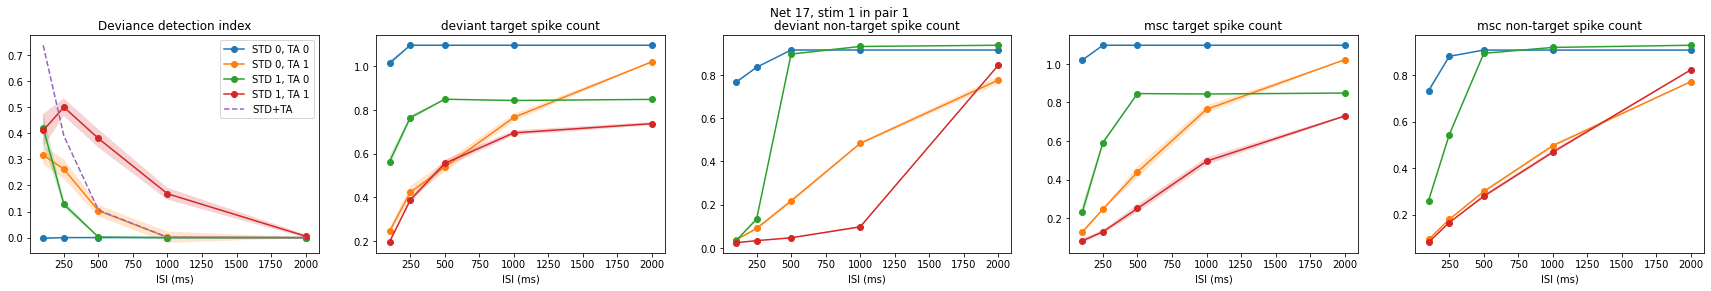

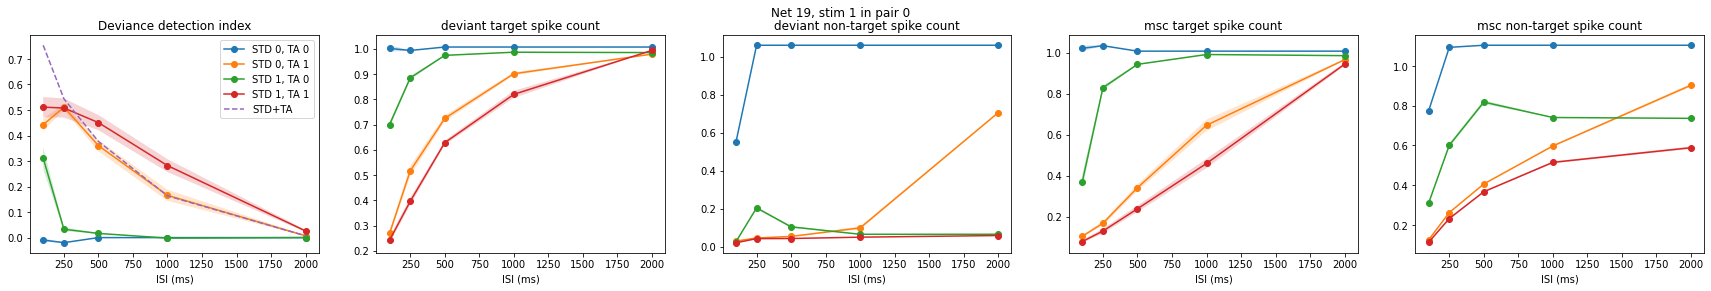

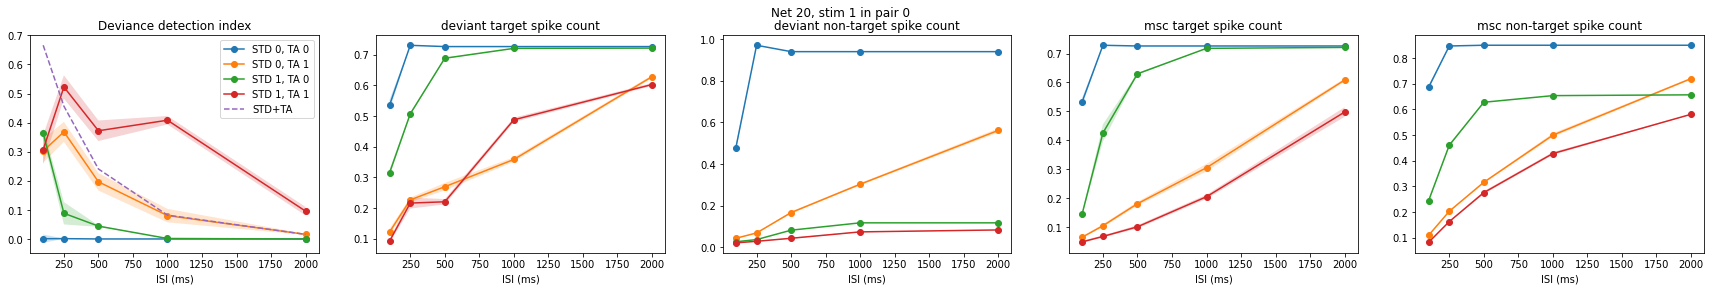

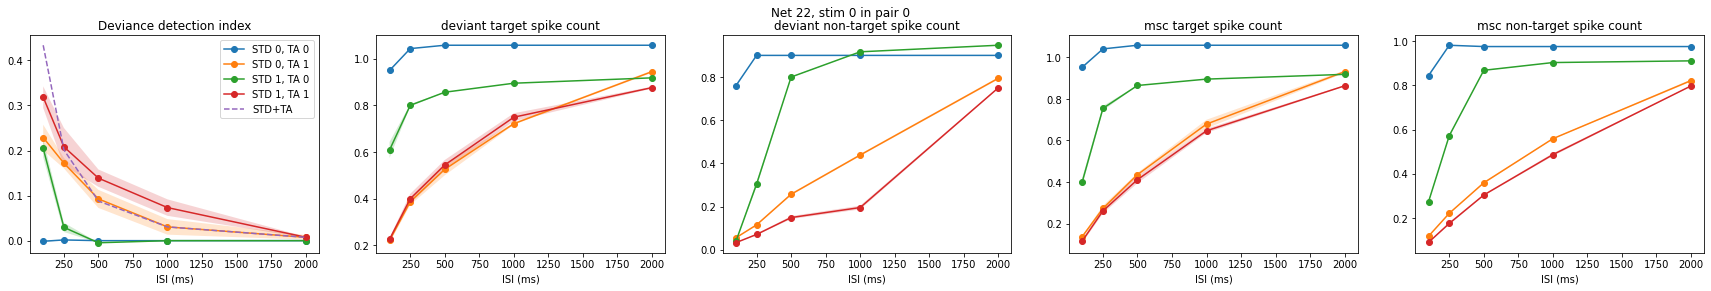

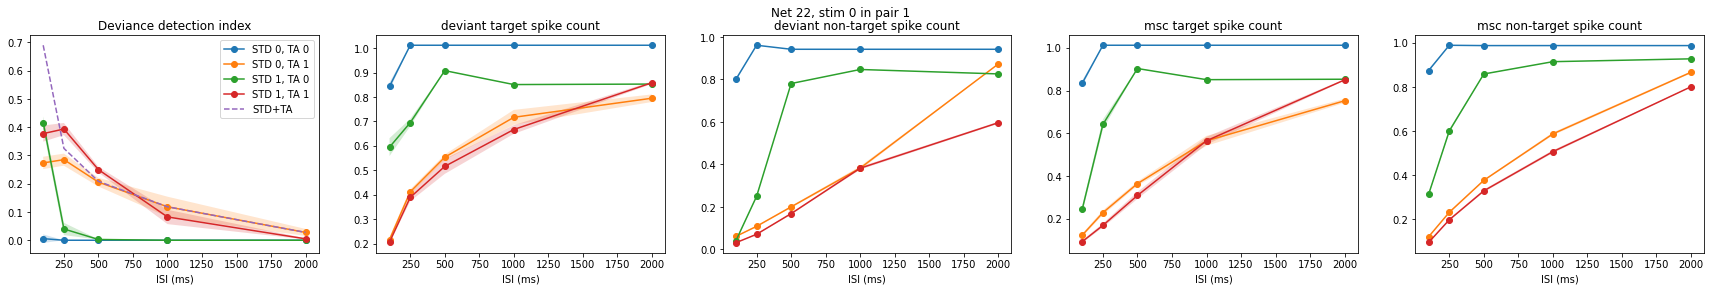

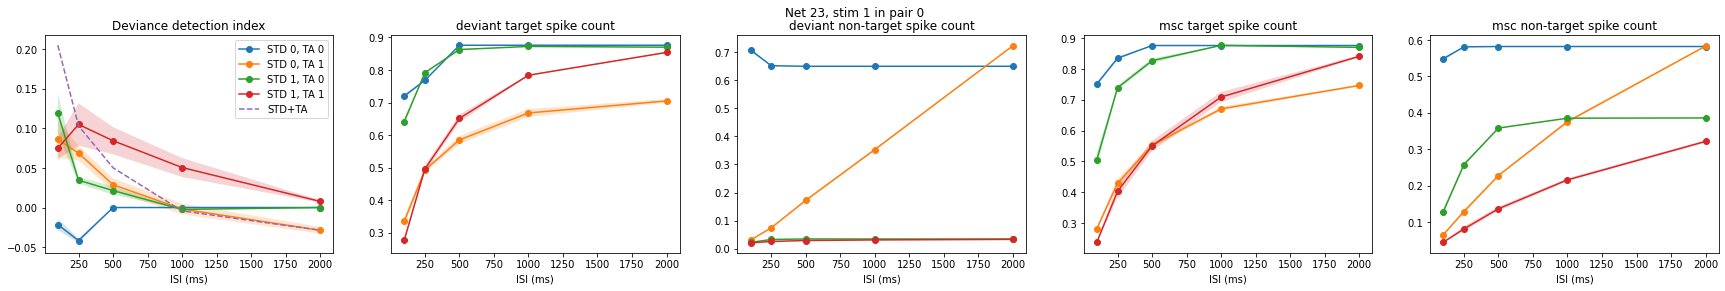

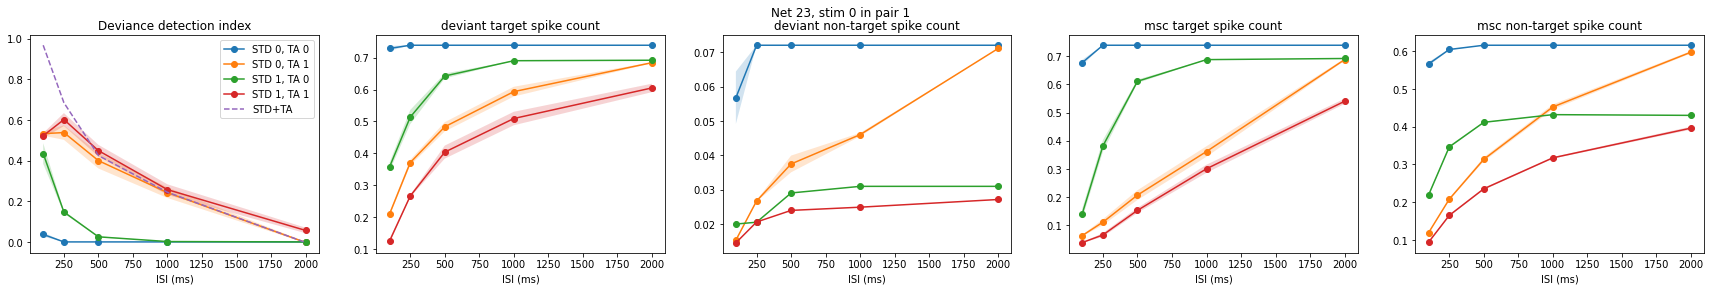

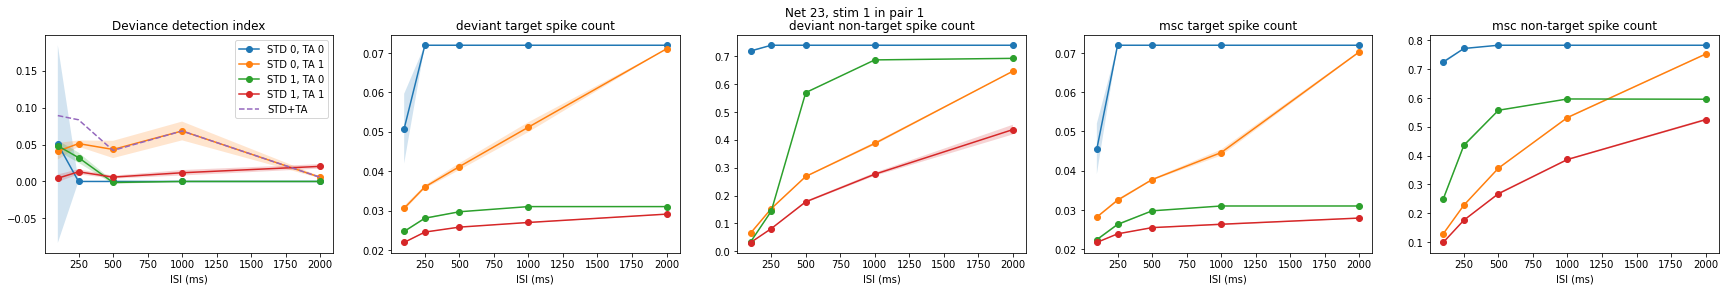

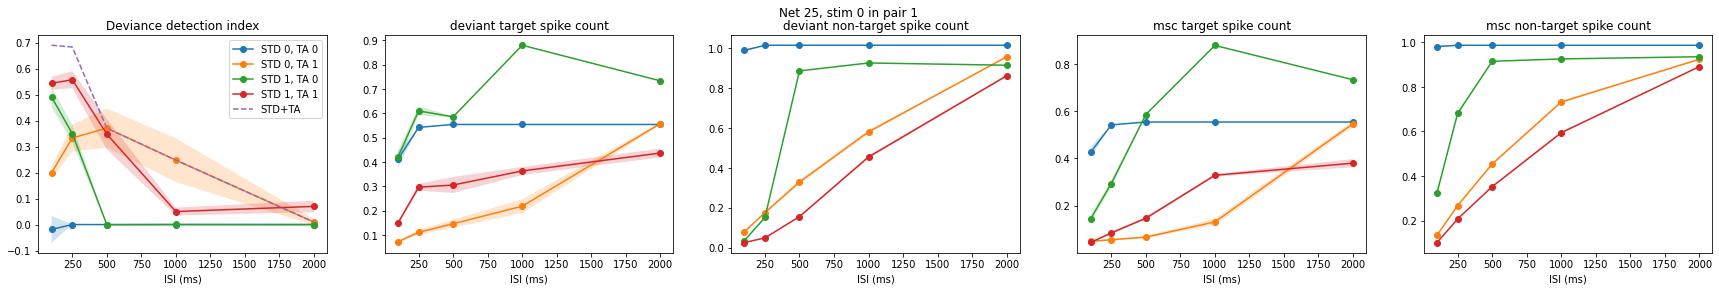

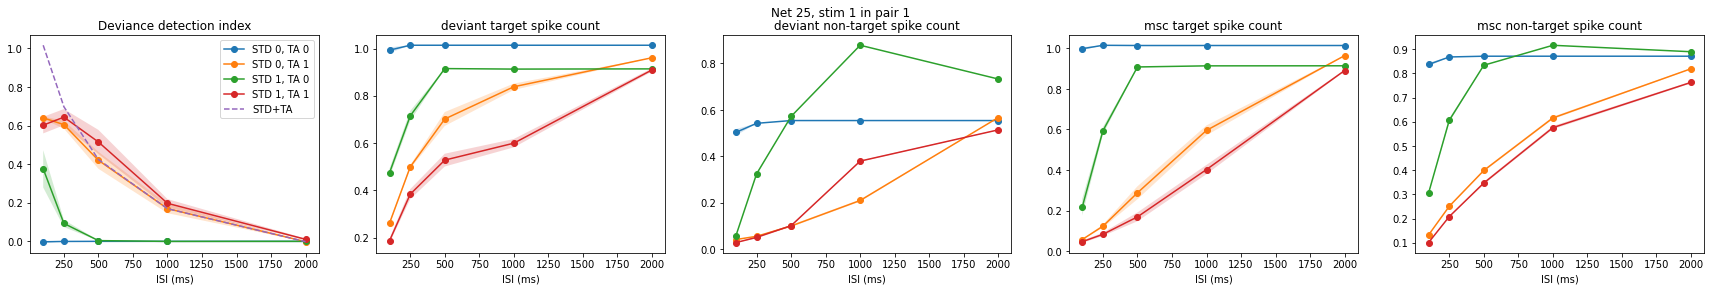

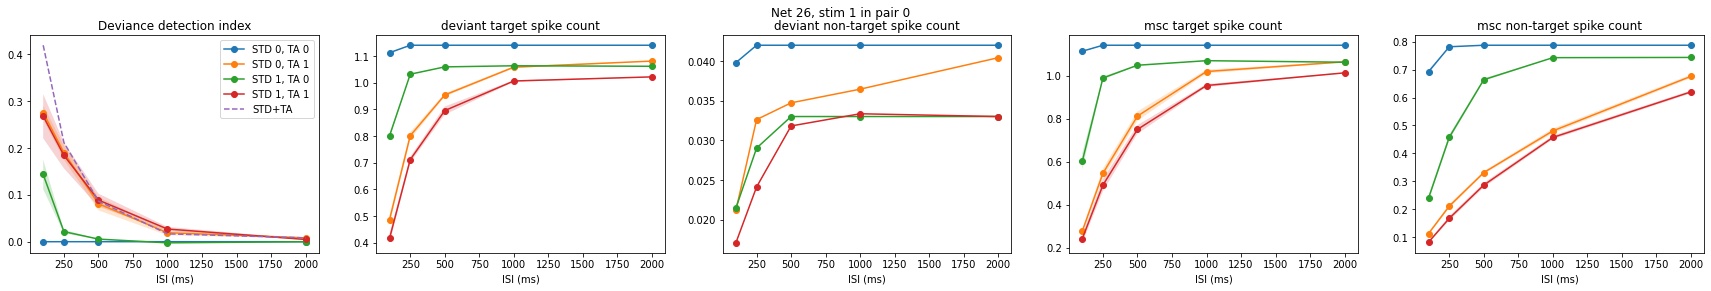

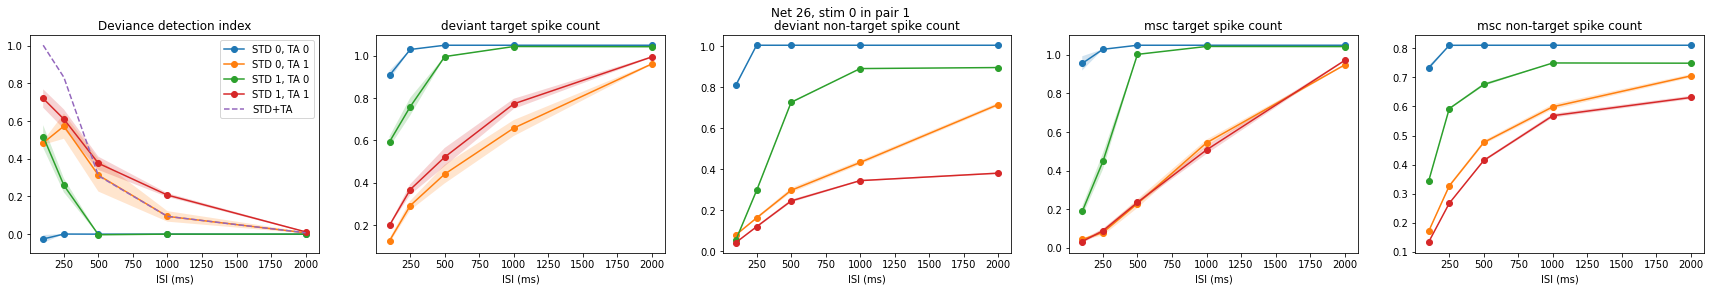

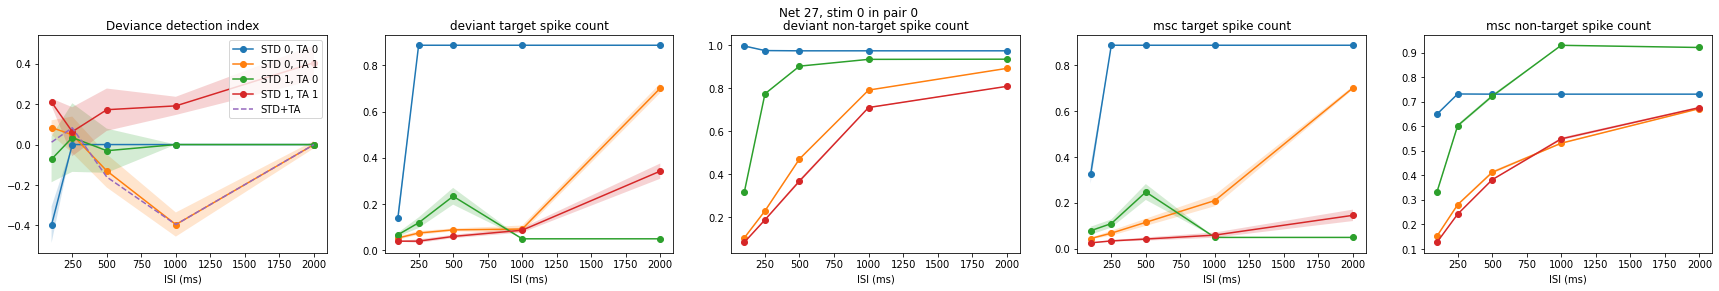

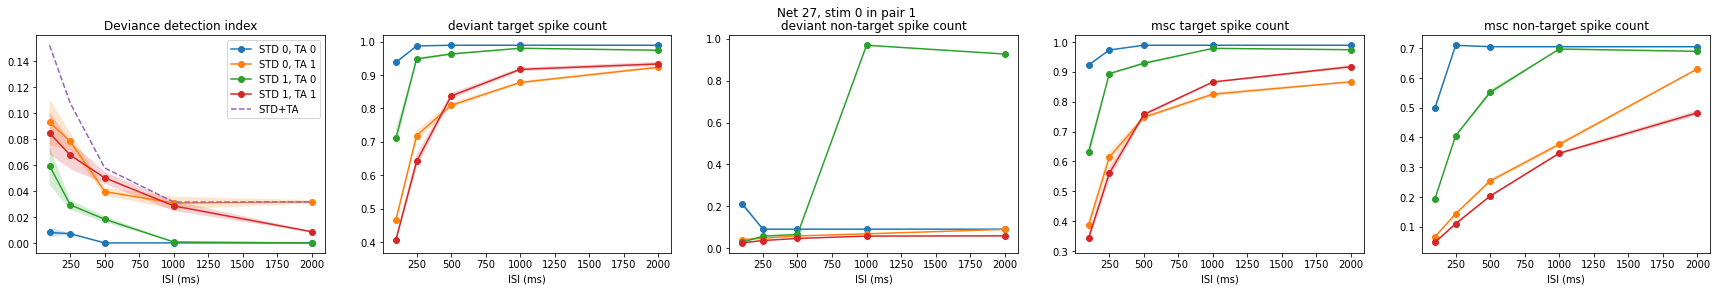

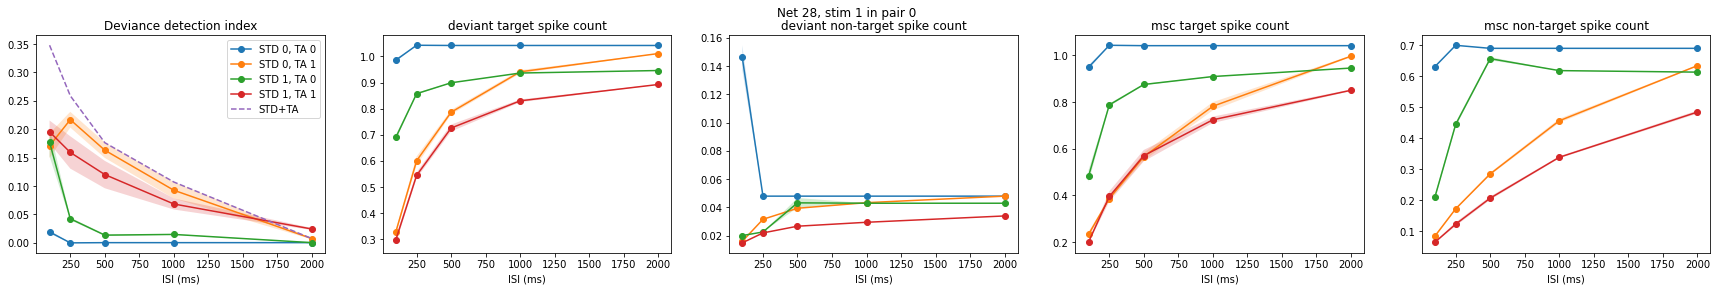

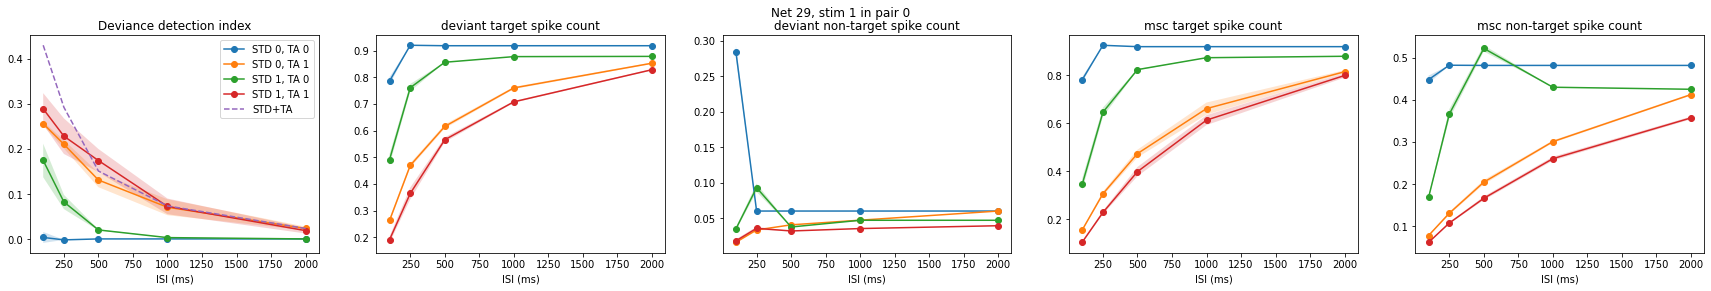

In [21]:
for net, mask_ in enumerate(mask):
 for ipair, mask__ in enumerate(mask_):
  for istim, valid in enumerate(mask__):
    if not valid:
        continue
    fig, axs = plt.subplots(1, 5, figsize=(30,4))
    fig.suptitle(f'Net {net}, stim {istim} in pair {ipair}')
    summed = 0
    for STD in cfg.STDs:
        for TA in cfg.TAs:
            n0, n1 = [nspikes[cond][getindex(net=net, STD=STD, TA=TA, ipair=ipair, istim=istim)[:-1]].mean(-1)
                      for cond in ('dev', 'msc')]  # templ, isi
            ddi = (n0-n1)/(n0+n1)
            the_mean = ddi.mean(0)
            the_std = ddi.std(0)
            axs[0].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[0].plot(cfg.ISIs, the_mean, '-o', label=f'STD {STD}, TA {TA}')
            if STD+TA == 1:
                summed = summed + the_mean
            
            the_mean, the_std = n0.mean(0), n0.std(0)
            axs[1].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[1].plot(cfg.ISIs, the_mean, '-o')
            
            n0_nontarget = nspikes['std'][getindex(net=net, STD=STD, TA=TA, ipair=ipair, istim=(1-istim))[:-1]].mean(-1)
            the_mean, the_std = n0_nontarget.mean(0), n0_nontarget.std(0)
            axs[2].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[2].plot(cfg.ISIs, the_mean, '-o')
            
            the_mean, the_std = n1.mean(0), n1.std(0)
            axs[3].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[3].plot(cfg.ISIs, the_mean, '-o')
            
            n1_nontarget = nspikes['nontarget_msc'][getindex(net=net, STD=STD, TA=TA, ipair=ipair, istim=istim)[:-1]].mean(-1)
            the_mean, the_std = n1_nontarget.mean(0), n1_nontarget.std(0)
            axs[4].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[4].plot(cfg.ISIs, the_mean, '-o')

    axs[0].plot(cfg.ISIs, summed, '--', label='STD+TA')

    for ax, title in zip(axs, ('Deviance detection index', 'deviant target spike count', 'deviant non-target spike count',
                               'msc target spike count', 'msc non-target spike count')):
        ax.set_title(title)
        ax.set_xlabel('ISI (ms)')
    axs[0].legend()

In [22]:
def get_ddi(nspikes, **kwargs):
    n0, n1 = [nspikes[cond][getindex(**kwargs)[:-1]].mean(-1)
              for cond in ('dev', 'msc')]  # templ, isi
    ddi = (n0-n1)/(n0+n1)
    return ddi.mean(0), ddi.std(0)

In [91]:
i = 0
full_model_ddi, summation_ddi = np.empty((2, mask.sum(), len(cfg.ISIs)))
all_fm_ddi, all_sum_ddi = np.empty((2, mask.size, len(cfg.ISIs)))
for net, mask_ in enumerate(mask):
 for ipair, mask__ in enumerate(mask_):
  for istim, valid in enumerate(mask__):
    fullmodel, _ = get_ddi(nspikes, net=net, ipair=ipair, istim=istim, STD=1, TA=1)
    noTA, _ = get_ddi(nspikes, net=net, ipair=ipair, istim=istim, STD=1, TA=0)
    noSTD, _ = get_ddi(nspikes, net=net, ipair=ipair, istim=istim, STD=0, TA=1)
    all_fm_ddi[i] = fullmodel
    all_sum_ddi[i] = noTA + noSTD
    i += 1
full_model_ddi = all_fm_ddi[mask.flatten()]
summation_ddi = all_sum_ddi[mask.flatten()]

Runs with full-model DDI > 0:

In [94]:
print(mask.sum(), '/', mask.size, 'runs selected')

36 / 120 runs selected


Text(0, 0.5, 'Full model DDI - summation DDI')

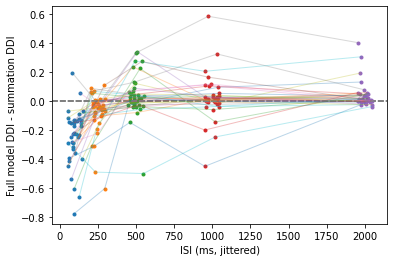

In [92]:
jitter = np.random.uniform(-50, 50, full_model_ddi.shape) + cfg.ISIs
for isi, full_, summ_ in zip(jitter.T, full_model_ddi.T, summation_ddi.T):
    plt.plot(isi, full_-summ_, 'o', ms=3)
    plt.axhline(0, ls='--', color='grey')
plt.plot(jitter.T, (full_model_ddi - summation_ddi).T, lw=1, alpha=.3)
plt.xlabel('ISI (ms, jittered)')
plt.ylabel('Full model DDI - summation DDI')

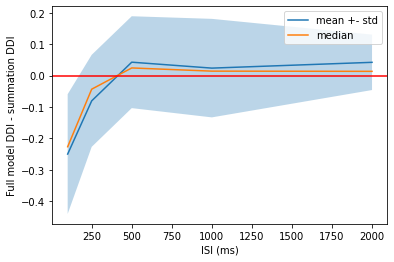

In [38]:
the_mean = np.mean(full_model_ddi - summation_ddi, 0)
the_std = np.std(full_model_ddi - summation_ddi, 0)
plt.fill_between(cfg.ISIs, the_mean+the_std, the_mean-the_std, alpha=.3)
plt.plot(cfg.ISIs, np.mean(full_model_ddi - summation_ddi, 0), label='mean +- std')
plt.plot(cfg.ISIs, np.median(full_model_ddi - summation_ddi, 0), label='median')
plt.axhline(0, color='r')
plt.legend()
plt.ylabel('Full model DDI - summation DDI')
plt.xlabel('ISI (ms)');

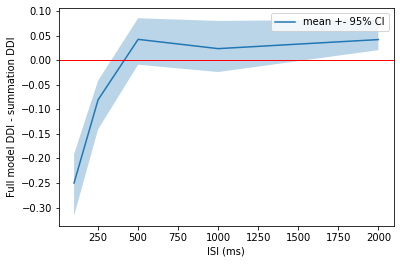

In [90]:
ci_lo, ci_hi = [], []
for ISI, delta in zip(cfg.ISIs, (full_model_ddi-summation_ddi).T):
    b = bootstrap((delta,), np.mean, confidence_level=.95)
    ci_lo.append(b.confidence_interval.low)
    ci_hi.append(b.confidence_interval.high)
plt.fill_between(cfg.ISIs, ci_lo, ci_hi, alpha=.3)
plt.plot(cfg.ISIs, np.mean(full_model_ddi - summation_ddi, 0), label='mean +- 95% CI')
plt.axhline(0, color='r', lw=1)
plt.legend()
plt.ylabel('Full model DDI - summation DDI')
plt.xlabel('ISI (ms)');

Text(0, 0.5, '<|full model DDI - summation DDI|>')

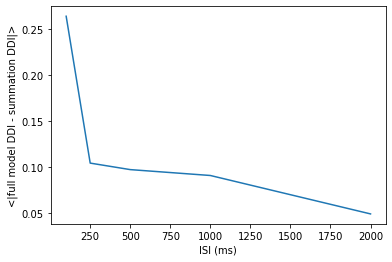

In [60]:
plt.plot(cfg.ISIs, np.abs(full_model_ddi-summation_ddi).mean(0))
plt.xlabel('ISI (ms)')
plt.ylabel('<|full model DDI - summation DDI|>')

WARNING    /tmp/ipykernel_303634/1999508473.py:1: RuntimeWarning: invalid value encountered in log
  logratio = np.log(full_model_ddi / summation_ddi)
 [py.warnings]


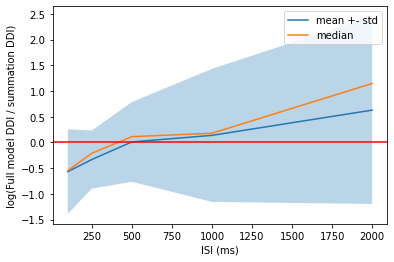

In [62]:
logratio = np.log(full_model_ddi / summation_ddi)
the_mean = np.nanmean(logratio, 0)
the_std = np.nanstd(logratio, 0)
plt.fill_between(cfg.ISIs, the_mean+the_std, the_mean-the_std, alpha=.3)
plt.plot(cfg.ISIs, the_mean, label='mean +- std')
plt.plot(cfg.ISIs, np.nanmedian(logratio, 0), label='median')
plt.axhline(0, color='r')
plt.legend()
plt.ylabel('log(Full model DDI / summation DDI)')
plt.xlabel('ISI (ms)');

All runs

Text(0, 0.5, 'Full model DDI - summation DDI')

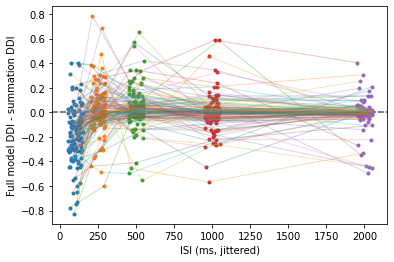

In [95]:
jitter = np.random.uniform(-50, 50, all_fm_ddi.shape) + cfg.ISIs
for isi, full_, summ_ in zip(jitter.T, all_fm_ddi.T, all_sum_ddi.T):
    plt.plot(isi, full_-summ_, 'o', ms=3)
    plt.axhline(0, ls='--', color='grey')
plt.plot(jitter.T, (all_fm_ddi - all_sum_ddi).T, lw=1, alpha=.3)
plt.xlabel('ISI (ms, jittered)')
plt.ylabel('Full model DDI - summation DDI')

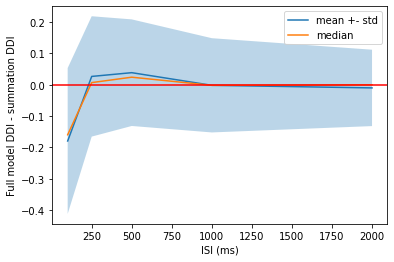

In [96]:
the_mean = np.mean(all_fm_ddi - all_sum_ddi, 0)
the_std = np.std(all_fm_ddi - all_sum_ddi, 0)
plt.fill_between(cfg.ISIs, the_mean+the_std, the_mean-the_std, alpha=.3)
plt.plot(cfg.ISIs, np.mean(all_fm_ddi - all_sum_ddi, 0), label='mean +- std')
plt.plot(cfg.ISIs, np.median(all_fm_ddi - all_sum_ddi, 0), label='median')
plt.axhline(0, color='r')
plt.legend()
plt.ylabel('Full model DDI - summation DDI')
plt.xlabel('ISI (ms)');

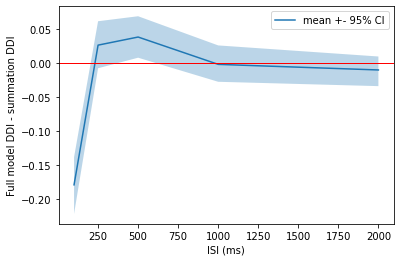

In [97]:
ci_lo, ci_hi = [], []
for ISI, delta in zip(cfg.ISIs, (all_fm_ddi-all_sum_ddi).T):
    b = bootstrap((delta,), np.mean, confidence_level=.95)
    ci_lo.append(b.confidence_interval.low)
    ci_hi.append(b.confidence_interval.high)
plt.fill_between(cfg.ISIs, ci_lo, ci_hi, alpha=.3)
plt.plot(cfg.ISIs, np.mean(all_fm_ddi - all_sum_ddi, 0), label='mean +- 95% CI')
plt.axhline(0, color='r', lw=1)
plt.legend()
plt.ylabel('Full model DDI - summation DDI')
plt.xlabel('ISI (ms)');

Text(0, 0.5, '<|full model DDI - summation DDI|>')

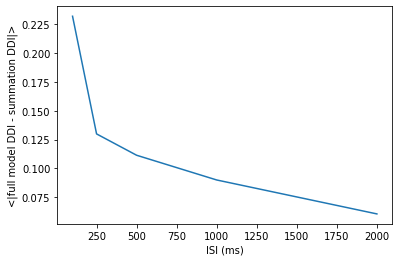

In [99]:
plt.plot(cfg.ISIs, np.abs(all_fm_ddi-all_sum_ddi).mean(0))
plt.xlabel('ISI (ms)')
plt.ylabel('<|full model DDI - summation DDI|>')

WARNING    /tmp/ipykernel_303634/944894240.py:1: RuntimeWarning: divide by zero encountered in true_divide
  logratio = np.log(all_fm_ddi / all_sum_ddi)
 [py.warnings]
WARNING    /tmp/ipykernel_303634/944894240.py:1: RuntimeWarning: divide by zero encountered in log
  logratio = np.log(all_fm_ddi / all_sum_ddi)
 [py.warnings]
WARNING    /tmp/ipykernel_303634/944894240.py:1: RuntimeWarning: invalid value encountered in log
  logratio = np.log(all_fm_ddi / all_sum_ddi)
 [py.warnings]
WARNING    /home/felix/projects/culture/.env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
 [py.warnings]


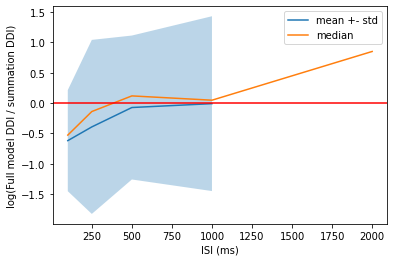

In [100]:
logratio = np.log(all_fm_ddi / all_sum_ddi)
the_mean = np.nanmean(logratio, 0)
the_std = np.nanstd(logratio, 0)
plt.fill_between(cfg.ISIs, the_mean+the_std, the_mean-the_std, alpha=.3)
plt.plot(cfg.ISIs, the_mean, label='mean +- std')
plt.plot(cfg.ISIs, np.nanmedian(logratio, 0), label='median')
plt.axhline(0, color='r')
plt.legend()
plt.ylabel('log(Full model DDI / summation DDI)')
plt.xlabel('ISI (ms)');